# Analysis Ready Data

In this tutorial, we will go over some of the basics to create dataloaders.

![](../assets/analysis_ready_data.png)

In [13]:
import autoroot
import os
import xarray as xr
import matplotlib.pyplot as plt
from xrpatcher import XRDAPatcher
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import itertools
from dotenv import load_dotenv
from rs_tools._src.utils.io import get_list_filenames

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



xr.set_options(
    keep_attrs=True, 
    display_expand_data=False, 
    display_expand_coords=False, 
    display_expand_data_vars=False, 
    display_expand_indexes=False
)
np.set_printoptions(threshold=10, edgeitems=2)

import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


save_dir = os.getenv("ITI_DATA_SAVEDIR")

## Scenes

In [14]:
save_dir = "/pool/usuarios/juanjohn/data/iti_v2"

list_of_files = get_list_filenames(f"{save_dir}/goes16/geoprocessed", ".nc")
len(list_of_files)

5

In [15]:
ds = xr.open_mfdataset(list_of_files, engine="netcdf4")
ds

<xarray.Dataset> Size: 647MB
Dimensions:          (x: 504, y: 3687, time: 5, band_wavelength: 16, band: 16)
Coordinates: (8)
Data variables: (1)
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-01T15:09:56.5Z
    time_coverage_start:       2020-10-01T15:00:19.6Z
    time_coverage_end:         2020-10-01T15:09:50.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        ae981973-758f-4213-b71e-e619d91ddddb

### Visualization

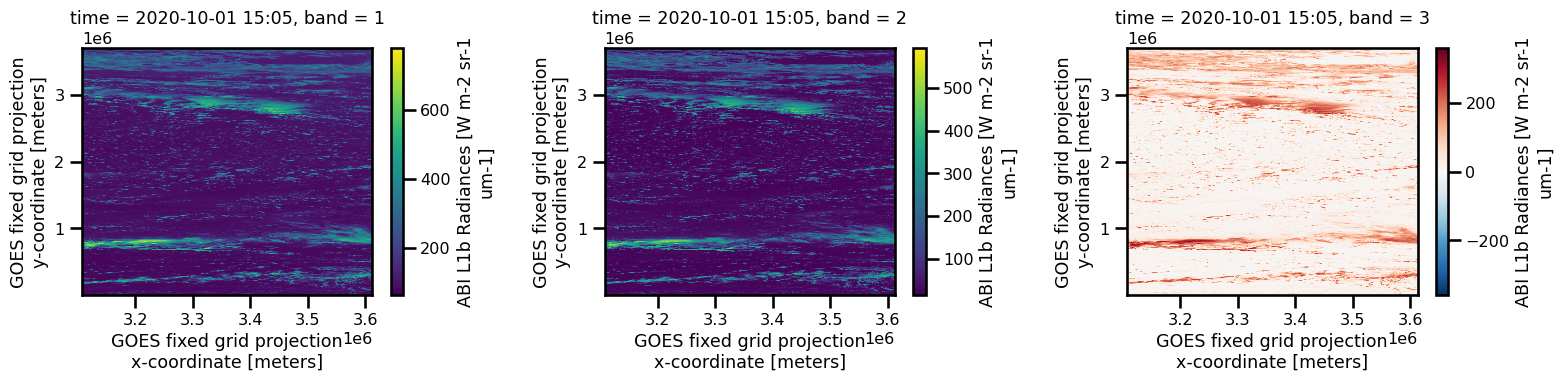

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
ds.isel(band=0, time=0).Rad.plot(ax=ax[0])
ds.isel(band=1, time=0).Rad.plot(ax=ax[1])
ds.isel(band=2, time=0).Rad.plot(ax=ax[2])
plt.tight_layout()
plt.show()

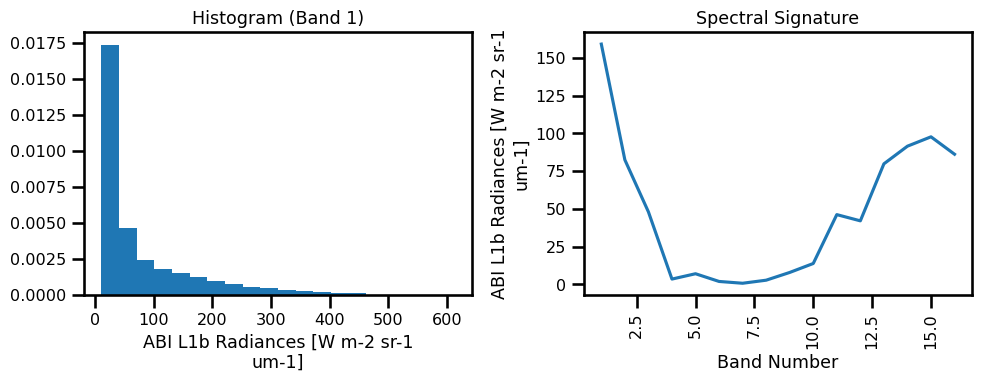

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ds.isel(band=1).Rad.plot.hist(ax=ax[0], bins=20, density=True)
ds.mean(["x", "y", "time"]).Rad.plot(ax=ax[1], x="band")
ax[0].set(title="Histogram (Band 1)")
ax[1].set(title="Spectral Signature", xlabel="Band Number")
ax[1].tick_params(axis="x", labelrotation=90)
plt.tight_layout()
plt.show()

## Patches

Very quickly, we will need to do computations on these large scenes.
So we can use some patching methods to do slice and dice the image into byte-sized chunks.

In [21]:
ds = xr.open_dataset(list_of_files[0], engine="netcdf4")

# create a variable to get a tensor
da = ds.to_array("variable")

# create patchsizes and stride sizes
patches = dict(x=64, y=64)
strides = dict(x=16, y=16)

# create a patcher object
patcher = XRDAPatcher(da, patches, strides)

# observe the patcher
patcher

XArray Patcher
DataArray Size: OrderedDict([('variable', 1), ('band', 16), ('y', 3687), ('x', 504)])
Patches:        OrderedDict([('variable', 1), ('band', 16), ('y', 64), ('x', 64)])
Strides:        OrderedDict([('variable', 1), ('band', 1), ('y', 16), ('x', 16)])
Num Items:    OrderedDict([('variable', 1), ('band', 1), ('y', 227), ('x', 28)])

We see that we have multiple patches available from the patcher.
In particular, we have a patchsize of `2x16x64x64` and we have `9x15` patches available for training.
Let's select a single element and observe the data type

In [22]:
patcher[0]

<xarray.DataArray (variable: 1, band: 16, y: 64, x: 64)> Size: 262kB
110.5 99.94 95.88 97.5 108.1 129.2 104.0 122.7 ... nan nan nan nan nan nan nan
Coordinates: (9)
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-01T15:09:56.5Z
    time_coverage_start:       2020-10-01T15:00:19.6Z
    time_coverage_end:         2020-10-01T15:09:50.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        ae981973-758f-4213-b71e-e619d91ddddb

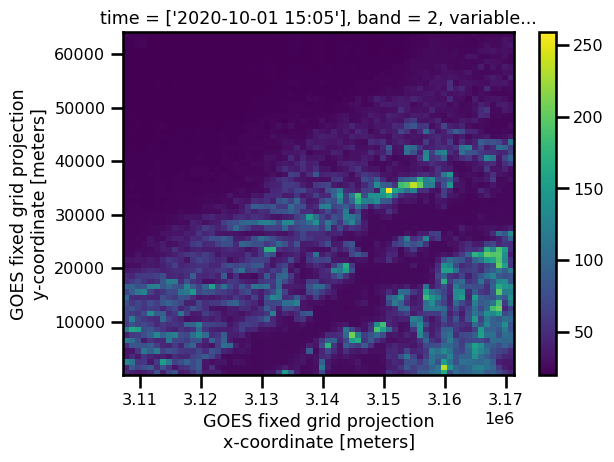

In [23]:
fig, ax = plt.subplots()

patcher[0].sel(variable="Rad").isel(band=1).plot(ax=ax)

plt.tight_layout()
plt.show()

Patches of Band 1


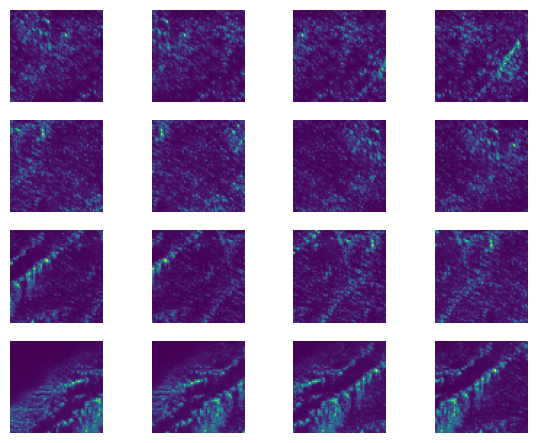

Patches of Band 2


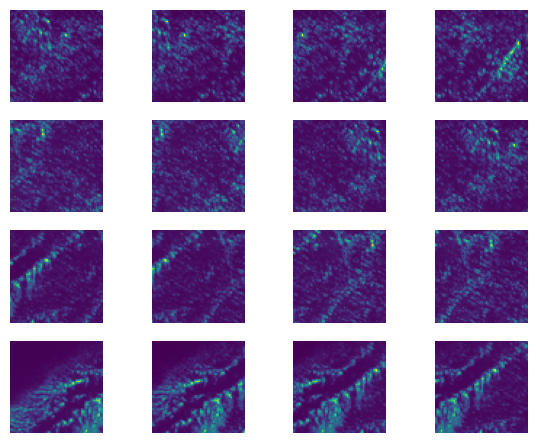

In [24]:
def plot_patches(items_to_plot, nbaxes=(4, 4)):
    fig, axs = plt.subplots(*nbaxes, figsize=(7.0, 5.5))

    for item, ax in zip(items_to_plot, [*itertools.chain(*reversed(axs))]):
        ax.imshow(item, origin="lower")
        ax.set_xticks([], labels=None)
        ax.set_axis_off()
        ax.set_yticks([], labels=None)


print("Patches of Band 1")
plot_patches([i.sel(variable="Rad").isel(band=1) for i in patcher])
plt.show()

print("Patches of Band 2")
plot_patches([i.sel(variable="Rad").isel(band=2) for i in patcher])
plt.show()

## Patch Reconstruction

Ultimately, when we get patches, we need to reconstruct them.
In this case, we will want to collect all patches from a scene and then merge them back together.

In [25]:
# create patchsizes and stride sizes
patches = dict(x=128, y=128)
strides = dict(x=64, y=64)

# create a patcher object
patcher = XRDAPatcher(da, patches, strides)

Imagine we had some operation that we wanted to apply on these patches.
For example,
* we may want to apply some local statistics (mean/variance/correlation)
* we may want to apply some operator to classify the pixels in the image
* we may want to apply some operator to translate images from one database to another.

In [26]:
from tqdm.auto import tqdm

all_patches = list()
for ipatch in tqdm(patcher):
    # apply function (in theory the ITI method)
    # ....
    all_patches.append(ipatch)
    

  0%|          | 0/336 [00:00<?, ?it/s]

In [27]:
da_recon = patcher.reconstruct(all_patches)

100%|██████████| 336/336 [00:08<00:00, 38.49it/s]


In [13]:
# np.testing.assert_array_almost_equal(da_recon.values, da.values, decimal=1)

In [28]:
da_recon.values.shape, da.values.shape

((1, 16, 3687, 504), (1, 16, 3687, 504))

***

### PyTorch Integration

We can also use directly plug this into a PyTorch dataset and dataloader.

In [29]:
class XrTorchDataset(Dataset):
    def __init__(self, batcher: XRDAPatcher, item_postpro=None):
        self.batcher = batcher
        self.postpro = item_postpro

    def __getitem__(self, idx):
        item = self.batcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item

    def reconstruct_from_batches(self, batches, **rec_kws):
        return self.batcher.reconstruct([*itertools.chain(*batches)], **rec_kws)

    def __len__(self):
        return len(self.batcher)

In [30]:
# create PyTorch dataset
torch_ds = XrTorchDataset(patcher)

len(torch_ds), torch_ds[0].shape, type(torch_ds[0])

(336, (1, 16, 128, 128), numpy.ndarray)

In [31]:
# create pytorch dataloader
dataloader = DataLoader(torch_ds, batch_size=4, shuffle=False)

# do a single iteration
batch = next(iter(dataloader))

batch.shape, type(batch)

(torch.Size([4, 1, 16, 128, 128]), torch.Tensor)

**Do not limit yourself**!

We have written this to be as agnostic as possible. 
So you do not have to use this example specifically.
You can plug in your favourite geo-specific library like:
* [TorchGeo](https://github.com/microsoft/torchgeo)
* [RasterVision](https://rastervision.io/)
* [GeoReader](https://github.com/spaceml-org/georeader)

In addition, you can choose any ML-framework you want and their respective dataloaders. 
Some good examples of framework independent methods include:
* [HuggingFace Datasets](https://huggingface.co/docs/datasets/how_to)
* [mlx-data](https://github.com/ml-explore/mlx-data)




#### Multiple Datasets

Many times we have multple datasets or scenes that we wish to use for training or some other preprocessing.
We can directly plug this into the `xrpatcher` framework and then use the PyTorch concat dataset to combine the different datasets.

First, let's create a simple concat dataset.

In [32]:
class XrConcatDataset(ConcatDataset):
    def __init__(self, *dses: XrTorchDataset):
        super().__init__(dses)

    def reconstruct_from_batches(self, batches, weight=None):
        items_iter = itertools.chain(*batches)
        rec_das = []
        for ds in self.datasets:
            ds_items = list(itertools.islice(items_iter, len(ds)))
            rec_das.append(ds.patcher.reconstruct(ds_items, weight=weight))

        return rec_das


In [33]:
# create individual patchers
patcher1 = XRDAPatcher(
    xr.open_dataset(list_of_files[0]).to_array("variable").squeeze(),
    patches, strides
)
patcher2 = XRDAPatcher(
    xr.open_dataset(list_of_files[1]).to_array("variable"),
    patches, strides
)


# create individual pytorch datasets
torch_ds1 = XrTorchDataset(patcher1)
torch_ds2 = XrTorchDataset(patcher2)

# create a concatenated dataset
torch_ds = XrConcatDataset(torch_ds1, torch_ds2)

len(torch_ds)

672

There is twice as much data available for training.